## Setup

In [3]:
import os
import time
import math

import numpy as np
import pandas as pd
from tqdm.notebook import trange
from matplotlib import pyplot as plt

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

ImportError: attempted relative import with no known parent package

In [15]:
%run utilities.ipynb

In [23]:
# Load data
over18 = load_csv("../data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("../data/bbc-pandemic/contact_distributions_u18.csv")

## Simulator

In [107]:
case_config, contacts_config, default_policy_config, _, _ = get_gp_config()

def simulate_policy(policy_parameters, n_cases = 10000):
    """
    Simulates a policy given by parameters.
    
    :param policy_parameters: a dictionary of policy parameter values.
        parameters not included will use default values
    :param n_cases: number of initial cases. Default value is 10000.
    
    :return: Pandas dataframe containing the results of the simulation:
        Base R, Effective R, # Manual Traces, # App Traces, # Tests Needed.
    """
    
    
    ## Compose all necessary configs
    policy_config = deepcopy(default_policy_config)
    for key, value in policy_parameters.items():
        policy_config[key] = value
    
    factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
    strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

    ## Simulation
    rng = np.random.RandomState(random.randint(0, 1000))

    simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
    tti_model = TTIFlowModel(rng, **strategy_config)

    outputs = list()
    
    for _ in range(n_cases):
        case = simulate_case(rng, **case_config)
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        contacts = simulate_contacts(case, **contacts_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)

    ## Process results
    to_show = [
        RETURN_KEYS.base_r,
        RETURN_KEYS.reduced_r,
        RETURN_KEYS.man_trace,
        RETURN_KEYS.app_trace,
        RETURN_KEYS.tests
    ]

    nppl = case_config['infection_proportions']['nppl']
    scales = [1, 1, nppl, nppl, nppl]

    results = pd.DataFrame(outputs).mean(0).loc[to_show].mul(scales)

    return results

## Random search

In [129]:
def effective_R_score(output):
    """ Returns the effective R from a simulation output """
    return output["Effective R"]

def linear_score(output, w_traces, w_tests):
    """ Returns a weighted sum of simulation output metrics """
    return (output["Effective R"] + 
        w_traces * output["# Manual Traces"] + 
        w_tests * output["# Tests Needed"])
    

In [113]:
BOOLEAN_PARAMS = ['isolate_individual_on_symptoms',  
    'isolate_individual_on_positive',  
    'isolate_household_on_symptoms',  
    'isolate_household_on_positive',  
    'isolate_contacts_on_symptoms',  
    'isolate_contacts_on_positive',  
    'test_contacts_on_positive',  
    'do_symptom_testing',  
    'do_manual_tracing', 
    'do_app_tracing']

# integer parameters include a range of possible values
INTEGER_PARAMS = {'max_contacts':(4, 50),'quarantine_length':(1, 14)}

PROB_PARAMS = ['go_to_school_prob','wfh_prob']

def random_parameters():
    """ Produces a random policy config. """
    params = {}
    for p in BOOLEAN_PARAMS:
        params[p] = bool(random.getrandbits(1))
    for p, p_range in INTEGER_PARAMS.items():
        params[p] = random.randint(p_range[0], p_range[1])
    for p in PROB_PARAMS:
        params[p] = random.random() 
            # can't generate 1., but tht would be unrealistic anyway
    return params

In [123]:
def random_search(n_iter, log_score=False, n_cases=10000, n_averaging=1, scoring_fun=effective_R_score):
    """
    Performs random search over the space of possible policies
    
    :param n_iter: number of random policies to be evaluated
    :param log_score: if True, it will log each improvement over the current best result.
    :param n_cases: number of initial cases
    :param n_averaging: number of simulations to be averaged for each policy
    :param scoring_fun: defines how to score a policy. Smaller score is better.
    
    :return: a tuple of: best score, best parameters, log of improvements
    """
    
    best_score = math.inf
    best_params = {}
    log = []
    start = time.time()
    
    for iter in range(n_iter):
        params = random_parameters()
        score = 0
        
        for j in range(n_averaging):
            output = simulate_policy(params, n_cases)
            score += scoring_fun(output)
        score /= n_averaging
        
        if (score < best_score):
            best_score = score
            best_params = params
            if (log_score):
                log.append((iter, time.time()-start, score))
                
    return (best_score, best_params, log)
    

## Experiments

In [136]:
res = random_search(50, log_score=True, n_averaging=2)

[(0, 7.754250764846802, 1.4472093320149995), (2, 24.262112855911255, 0.9137768850752104), (40, 303.83202266693115, 0.8901002943041791)]


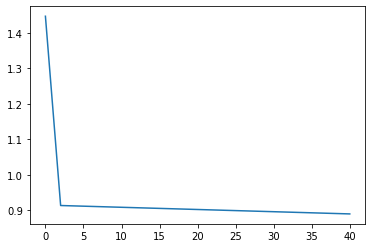

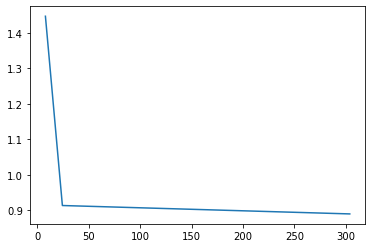

In [137]:
log = res[2]
print(log)
it = [log[i][0] for i in range(len(log))]
ts = [log[i][1] for i in range(len(log))]
sc = [log[i][2] for i in range(len(log))]
plt.plot(it, sc)
plt.show()
plt.plot(ts, sc)
plt.show()

In [124]:
random_search(10, log_score=False)

(1.0714940980388443,
 {'isolate_individual_on_symptoms': True,
  'isolate_individual_on_positive': True,
  'isolate_household_on_symptoms': True,
  'isolate_household_on_positive': False,
  'isolate_contacts_on_symptoms': True,
  'isolate_contacts_on_positive': False,
  'test_contacts_on_positive': True,
  'do_symptom_testing': False,
  'do_manual_tracing': False,
  'do_app_tracing': True,
  'max_contacts': 12,
  'quarantine_length': 5,
  'go_to_school_prob': 0.5748053074363833,
  'wfh_prob': 0.9081864687899798},
 [])

In [130]:
fun = (lambda x: linear_score(x, 0.005, 0.0125))

random_search(10, log_score=False, scoring_fun=fun)

(2.306719138390192,
 {'isolate_individual_on_symptoms': True,
  'isolate_individual_on_positive': False,
  'isolate_household_on_symptoms': True,
  'isolate_household_on_positive': False,
  'isolate_contacts_on_symptoms': True,
  'isolate_contacts_on_positive': True,
  'test_contacts_on_positive': False,
  'do_symptom_testing': False,
  'do_manual_tracing': False,
  'do_app_tracing': False,
  'max_contacts': 50,
  'quarantine_length': 10,
  'go_to_school_prob': 0.12377269802635849,
  'wfh_prob': 0.8445299323364991},
 [])

Since no cost to policy is considered, the obvious result will be extremely harsh:

In [122]:
extreme_policy = {'isolate_individual_on_symptoms': False,
  'isolate_individual_on_positive': True,
  'isolate_household_on_symptoms': True,
  'isolate_household_on_positive': True,
  'isolate_contacts_on_symptoms': True,
  'isolate_contacts_on_positive': True,
  'test_contacts_on_positive': True,
  'do_symptom_testing': True,
  'do_manual_tracing': True,
  'do_app_tracing': True,
  'max_contacts': 4,
  'quarantine_length': 14,
  'go_to_school_prob': 0.,
  'wfh_prob': 0.9945621884880474}

n_iter = 10
l = [effective_R_score(simulate_policy(extreme_policy, 10000))
     for i in range(n_iter)]
print("average:", sum(l)/n_iter)
print("range:", min(l), "-", max(l))

average: 0.6330139275417823
range: 0.5831600161473212 - 0.6742029054716775


## Parameters

In [ ]:
parameters = {
    'isolate_individual_on_symptoms':True,  # Isolate the individual after they present with symptoms
    'isolate_individual_on_positive':True,  # Isolate the individual after they test positive
    'isolate_household_on_symptoms':False,  # Isolate the household after individual present with symptoms
    'isolate_household_on_positive':True,  # Isolate the household after individual test positive
    'isolate_contacts_on_symptoms':False,  # Isolate the contacts after individual present with symptoms
    'isolate_contacts_on_positive':True,  # Isolate the contacts after individual test positive
    'test_contacts_on_positive':False,  # Do we test contacts of a positive case immediately, or wait for them to develop symptoms
    'do_symptom_testing':True,  # Test symptomatic individuals
    'do_manual_tracing':True,  # Perform manual tracing of contacts
    'do_app_tracing':True,  # Perform app tracing of contacts
    'max_contacts':23,  # Place a limit on the number of other contacts per day
    'quarantine_length':14,  # Length of quarantine imposed on COVID cases (and household)
    'go_to_school_prob':1.0,  # Fraction of school children attending school
    'wfh_prob':0.0,  # Proportion or the population working from home
    }